**Author:** Raoul Malm  

**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import math
import datetime
import os
import matplotlib.pyplot as plt

# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from prices-split-adjusted.csv
- analyze data

In [2]:
# import all stock prices 
df = pd.read_csv("./prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['HCN', 'TDC', 'HON', 'CPB', 'HSIC', 'DFS', 'SYY', 'FTI', 'WAT', 'DHR']


In [3]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [4]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


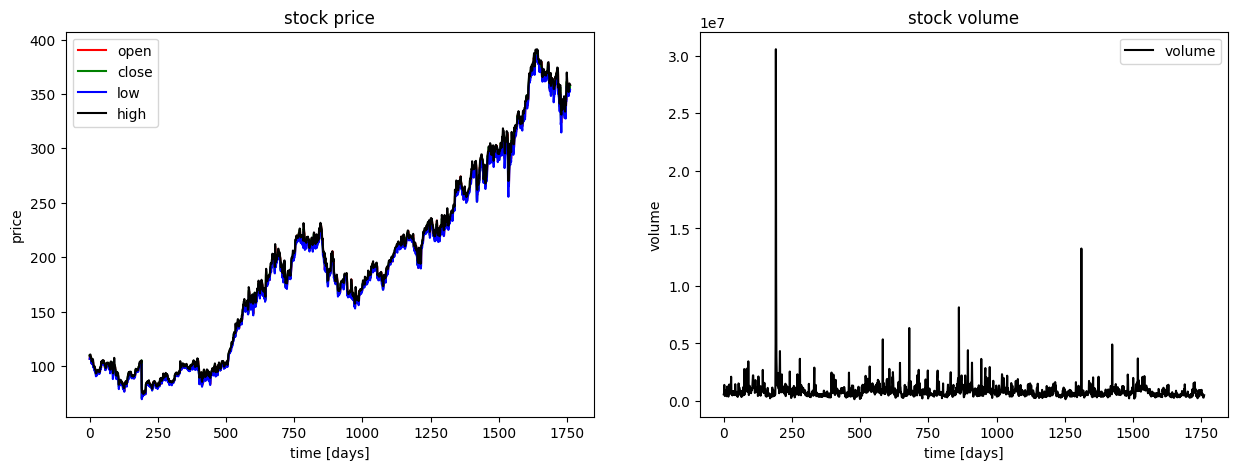

In [6]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock and drop feature volume
- split train and test sets
- normalize stock data
- window sliding

**choose a specific stock and drop feature volume**

In [7]:
# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'], axis=1, inplace=True)
df_stock.drop(['volume'], axis=1, inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

df_stock.columns.values =  ['open', 'close', 'low', 'high']


**split train and test sets**

In [8]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_stock, df_stock[['open']], test_size=test_size, random_state=42, shuffle=False)

In [9]:
X_train.shape

(1409, 4)

In [10]:
X_test.shape

(353, 4)

In [11]:
y_train.shape

(1409, 1)

In [12]:
y_test.shape

(353, 1)

In [13]:
X_train.head()

,open,close,low,high
date,,,,
2010-01-04,106.519997,109.559998,106.510002,109.620003
2010-01-05,109.589996,108.540001,108.379997,109.589996
2010-01-06,108.949997,109.529999,108.220001,110.570000
2010-01-07,109.250000,107.290001,106.639999,110.349998
2010-01-08,106.800003,106.769997,105.900002,107.279999


**normalize data**

In [14]:
from sklearn.preprocessing import MinMaxScaler

# function for min-max normalization of stock
def normalize_data(data):
    # instantiate scalers
    sc = MinMaxScaler(feature_range=(-1, 1))
    data_scaled = sc.fit_transform(data)

    return data_scaled, sc

In [15]:
X_train_norm, _ = normalize_data(X_train)
y_train_norm, _ = normalize_data(y_train)

In [16]:
X_train_norm.shape

(1409, 4)

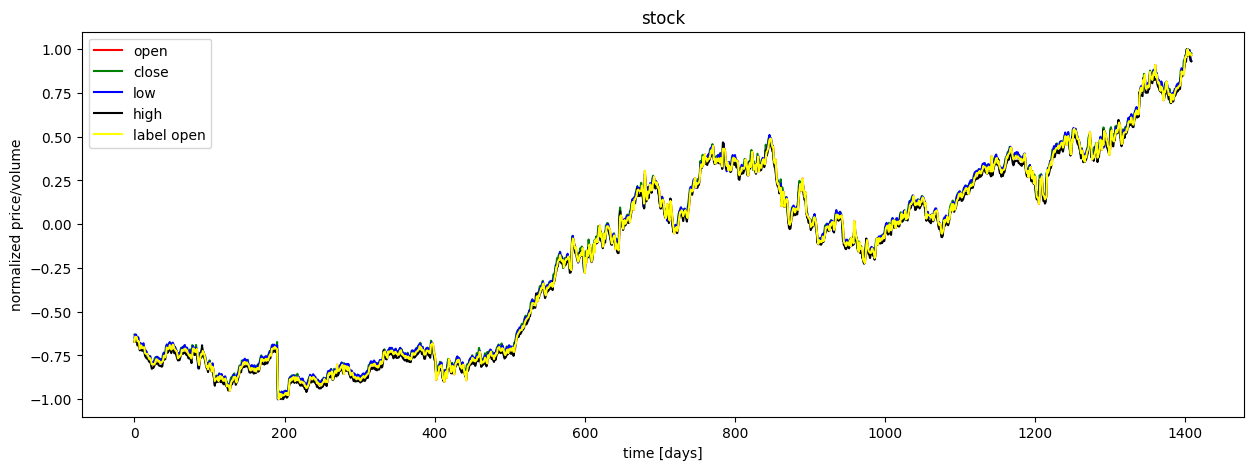

In [17]:
plt.figure(figsize=(15, 5));
plt.plot(X_train_norm[:, 0], color='red', label='open')
plt.plot(X_train_norm[:, 1], color='green', label='close')
plt.plot(X_train_norm[:, 2], color='blue', label='low')
plt.plot(X_train_norm[:, 3], color='black', label='high')
plt.plot(y_train_norm, color='yellow', label='label open')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

**window sliding**

In [18]:
# convert train_norm to a tensor
X_train_norm = torch.FloatTensor(X_train_norm).view((-1, 4))
y_train_norm = torch.FloatTensor(y_train_norm).view(-1)

In [19]:
X_train_norm.shape

torch.Size([1409, 4])

In [20]:
# define a function to create sequence/label tuples
def input_data(dataX,datay,ws):
    out = []
    L = len(dataX)
    for i in range(L-ws):
        window = dataX[i:i+ws]
        label = datay[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [21]:
# define a window size
window_size = 20
# apply X_train_norm and y_train_norm to get window sliding results
train = input_data(X_train_norm, y_train_norm, window_size)

In [22]:
len(train)

1389

In [23]:
train[0]

(tensor([[-0.6719, -0.6310, -0.6478, -0.6713],
         [-0.6429, -0.6406, -0.6301, -0.6716],
         [-0.6489, -0.6312, -0.6316, -0.6624],
         [-0.6461, -0.6523, -0.6466, -0.6644],
         [-0.6692, -0.6572, -0.6536, -0.6932],
         [-0.6676, -0.6489, -0.6460, -0.6850],
         [-0.6711, -0.6900, -0.6815, -0.6897],
         [-0.7122, -0.6919, -0.6883, -0.7205],
         [-0.7021, -0.6821, -0.6781, -0.7167],
         [-0.6921, -0.7011, -0.6949, -0.7194],
         [-0.7080, -0.6839, -0.6945, -0.7224],
         [-0.7065, -0.6884, -0.6909, -0.7236],
         [-0.7033, -0.6892, -0.6800, -0.7027],
         [-0.7032, -0.7301, -0.7223, -0.7215],
         [-0.7357, -0.7201, -0.7182, -0.7510],
         [-0.7391, -0.7260, -0.7213, -0.7596],
         [-0.7438, -0.7280, -0.7303, -0.7653],
         [-0.7412, -0.7420, -0.7490, -0.7691],
         [-0.7511, -0.7564, -0.7476, -0.7641],
         [-0.7646, -0.7600, -0.7543, -0.7818]]),
 tensor([-0.7720]))

In [24]:
print(f"intput shape: {train[0][0].shape}")
print(f"label shape: {train[0][1].shape}")

intput shape: torch.Size([20, 4])
label shape: torch.Size([1])


# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 

In [25]:
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Dropout

In [26]:
# print(keras.__version__)

In [27]:
# # reference: https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-rnn-lstm-8d840f3f9aa7
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(20, 4)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(1))

In [28]:
# epoch = 100
# batch = 32
# lr = 1e-3
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
#               loss=keras.losses.MeanSquaredError())
# model.fit(X_train_shape, y_train, epochs=epoch, batch_size=batch)

In [29]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=4,hidden_size=100,
                 output_size=1,num_layers=2,dropout=0.2,batch_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size, 
                            num_layers=num_layers, dropout=dropout)
        
        # add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(num_layers,self.batch_size,self.hidden_size),
                       torch.zeros(num_layers,self.batch_size,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),self.batch_size,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

**instantiation, loss, and optimizer**

In [30]:
torch.manual_seed(42)

# instantiate
input_size = 4
hidden_size = 10
output_size = 1
num_layers = 2
dropout = 0.2
batch_size = 1

model = LSTMnetwork(input_size=input_size,hidden_size=hidden_size,
                     output_size=output_size,num_layers=num_layers,
                     dropout=dropout,batch_size=batch_size)

# loss
criterion = nn.MSELoss()

#optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

LSTMnetwork(
  (lstm): LSTM(4, 10, num_layers=2, dropout=0.2)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

**training**

In [31]:
epochs = 50

import time
start_time = time.time()

loss_list = []
for epoch in range(epochs):
    for seq, y_train in train:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(num_layers, batch_size, model.hidden_size),
                        torch.zeros(num_layers, batch_size, model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    loss_list.append(loss.item())
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01163682
Epoch:  2 Loss: 0.00116765
Epoch:  3 Loss: 0.00074501
Epoch:  4 Loss: 0.00446599
Epoch:  5 Loss: 0.00297245
Epoch:  6 Loss: 0.00067429
Epoch:  7 Loss: 0.00140712
Epoch:  8 Loss: 0.00053538
Epoch:  9 Loss: 0.00235886
Epoch: 10 Loss: 0.00039951
Epoch: 11 Loss: 0.00026611
Epoch: 12 Loss: 0.00000493
Epoch: 13 Loss: 0.00008902
Epoch: 14 Loss: 0.00052716
Epoch: 15 Loss: 0.00032155
Epoch: 16 Loss: 0.00039732
Epoch: 17 Loss: 0.00065295
Epoch: 18 Loss: 0.00010408
Epoch: 19 Loss: 0.00018024
Epoch: 20 Loss: 0.00003840
Epoch: 21 Loss: 0.00236485
Epoch: 22 Loss: 0.00006836
Epoch: 23 Loss: 0.00045709
Epoch: 24 Loss: 0.00028508
Epoch: 25 Loss: 0.00002726
Epoch: 26 Loss: 0.00073544
Epoch: 27 Loss: 0.00002082
Epoch: 28 Loss: 0.00000059
Epoch: 29 Loss: 0.00002858
Epoch: 30 Loss: 0.00033602
Epoch: 31 Loss: 0.00000714
Epoch: 32 Loss: 0.00075419
Epoch: 33 Loss: 0.00258890
Epoch: 34 Loss: 0.00026331
Epoch: 35 Loss: 0.00061655
Epoch: 36 Loss: 0.00001434
Epoch: 37 Loss: 0.00021226
E

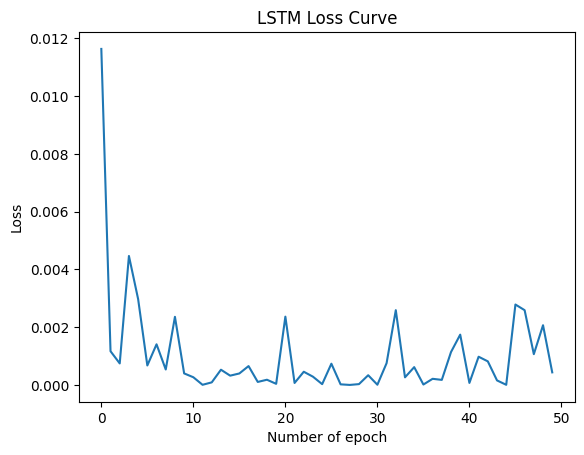

In [32]:
# visualization loss 
plt.plot(list(range(len(loss_list))),loss_list)
plt.xlabel("Number of epoch")
plt.ylabel("Loss")
plt.title("LSTM Loss Curve")
plt.show()

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

**test set normalization**

In [33]:
X_test_norm, scaler_X_test = normalize_data(X_test)
y_test_norm, scaler_y_test = normalize_data(y_test)

**test set window sliding**

In [34]:
# convert train_norm to a tensor
X_test_norm = torch.FloatTensor(X_test_norm).view((-1, 4))
y_test_norm = torch.FloatTensor(y_test_norm).view(-1)

In [35]:
# apply X_train_norm and y_train_norm to get window sliding results
test = input_data(X_test_norm, y_test_norm, window_size)

**test set prediction**

In [36]:
testset_size = len(test)

preds = []

model.eval()

for i in range(testset_size):
    seq = test[i][0]
    with torch.no_grad():
        model.hidden = (torch.zeros(num_layers,1,model.hidden_size),
                        torch.zeros(num_layers,1,model.hidden_size))
        preds.append(model(seq).item())

In [37]:
len(preds)

333

In [38]:
len(y_test_norm[window_size:])

333

**inverting the normalized values**

In [39]:
true_predictions = scaler_y_test.inverse_transform(np.array(preds).reshape(-1, 1))
true_predictions

array([[285.68242961],
       [286.64628372],
       [288.21678552],
       [289.17853902],
       [290.75608776],
       [292.56939608],
       [293.99409982],
       [294.80046381],
       [296.44680153],
       [295.44814866],
       [297.51199214],
       [296.63383492],
       [296.62166724],
       [294.13745641],
       [292.68606306],
       [290.13039192],
       [287.9300327 ],
       [287.70698775],
       [288.30834825],
       [288.45992496],
       [290.31696555],
       [287.89609797],
       [286.25629988],
       [285.76233198],
       [285.96068487],
       [286.36207541],
       [286.20644016],
       [286.44681314],
       [287.39086605],
       [289.48113756],
       [292.04589283],
       [294.71659803],
       [296.71949216],
       [298.86487887],
       [300.4270258 ],
       [304.97162401],
       [303.72085854],
       [302.66743926],
       [302.02937757],
       [303.47859898],
       [309.11985333],
       [307.06897417],
       [305.50417969],
       [304

In [40]:
y_test

,open
date,
2015-08-10,282.890015
2015-08-11,278.429993
2015-08-12,277.440002
2015-08-13,283.970001
2015-08-14,285.109985
...,...
2016-12-23,352.100006
2016-12-27,356.779999
2016-12-28,357.220001


**plotting**

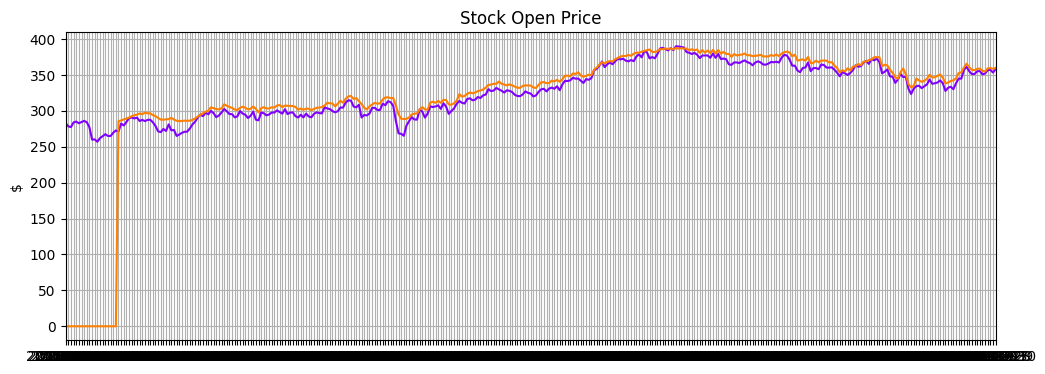

In [43]:
fig = plt.figure(figsize=(12,4))
x = list(X_test.index)
plt.title('Stock Open Price')
plt.ylabel('$')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
# fig.autofmt_xdate()

predict = np.vstack((np.zeros(window_size).reshape(-1, 1), true_predictions))
plt.plot(x, list(X_test.iloc[:, 0]), color='#8000ff')
plt.plot(x, predict, color='#ff8000')
plt.show()